<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_cifar10_mse_HeNormal_L0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 200
batch_size = 128

initializer = initializers.HeNormal(seed=100)

In [3]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteCY21A8/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteCY21A8/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

In [5]:
img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [6]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 2, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(1024, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        832       
                                                                 
 re_lu (ReLU)                (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        16448     
                                                                 
 re_lu_1 (ReLU)              (None, 30, 30, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                           

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(8*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = layers.Conv2DTranspose(1024, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

x = layers.Conv2DTranspose(8, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 400)               80400     
                                                                 
 re_lu_18 (ReLU)             (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 800)               320800    
                                                                 
 re_lu_19 (ReLU)             (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 1600)              1281600   
                                                                 
 re_lu_20 (ReLU)             (None, 1600)              0   

In [8]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 200)               9306744   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         14275419  
                                                                 
Total params: 23582163 (89.96 MB)
Trainable params: 23580627 (89.95 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


In [23]:
K.clear_session()

In [9]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=200, decay_rate=0.995)
optim = keras.optimizers.Adam(learning_rate = 0.001)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')

In [10]:
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, steps_per_epoch=None)

Epoch 1/20
391/391 [==============================] - 68s 116ms/step - loss: 0.0457 - val_loss: 0.0534
Epoch 2/20
391/391 [==============================] - 37s 95ms/step - loss: 0.0381 - val_loss: 0.0538
Epoch 3/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0350 - val_loss: 0.0450
Epoch 4/20
391/391 [==============================] - 36s 93ms/step - loss: 0.0324 - val_loss: 0.0389
Epoch 5/20
391/391 [==============================] - 36s 93ms/step - loss: 0.0315 - val_loss: 0.0334
Epoch 6/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0313 - val_loss: 0.0445
Epoch 7/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0310 - val_loss: 0.0310
Epoch 8/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0311 - val_loss: 0.0511
Epoch 9/20
391/391 [==============================] - 36s 93ms/step - loss: 0.0308 - val_loss: 0.0305
Epoch 10/20
391/391 [==============================] - 36s 92ms/step - loss: 0.03

In [11]:
optim = keras.optimizers.Adam(learning_rate = 0.00075)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, steps_per_epoch=None)

Epoch 1/20
391/391 [==============================] - 53s 94ms/step - loss: 0.0245 - val_loss: 0.0279
Epoch 2/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0243 - val_loss: 0.0335
Epoch 3/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0242 - val_loss: 0.0302
Epoch 4/20
391/391 [==============================] - 36s 93ms/step - loss: 0.0240 - val_loss: 0.0248
Epoch 5/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0239 - val_loss: 0.0295
Epoch 6/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0238 - val_loss: 0.0261
Epoch 7/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0234 - val_loss: 0.0236
Epoch 8/20
391/391 [==============================] - 36s 92ms/step - loss: 0.0231 - val_loss: 0.0295
Epoch 9/20
391/391 [==============================] - 36s 91ms/step - loss: 0.0230 - val_loss: 0.0237
Epoch 10/20
391/391 [==============================] - 36s 91ms/step - loss: 0.022

In [12]:
optim = keras.optimizers.Adam(learning_rate = 0.00025)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
391/391 [==============================] - 47s 92ms/step - loss: 0.0209 - val_loss: 0.0222
Epoch 2/15
391/391 [==============================] - 36s 92ms/step - loss: 0.0207 - val_loss: 0.0224
Epoch 3/15
391/391 [==============================] - 36s 92ms/step - loss: 0.0207 - val_loss: 0.0220
Epoch 4/15
391/391 [==============================] - 36s 92ms/step - loss: 0.0206 - val_loss: 0.0220
Epoch 5/15
391/391 [==============================] - 36s 93ms/step - loss: 0.0205 - val_loss: 0.0218
Epoch 6/15
391/391 [==============================] - 36s 92ms/step - loss: 0.0204 - val_loss: 0.0219
Epoch 7/15
391/391 [==============================] - 36s 92ms/step - loss: 0.0204 - val_loss: 0.0216
Epoch 8/15
391/391 [==============================] - 36s 92ms/step - loss: 0.0203 - val_loss: 0.0220
Epoch 9/15
391/391 [==============================] - 36s 92ms/step - loss: 0.0203 - val_loss: 0.0218
Epoch 10/15
391/391 [==============================] - 36s 91ms/step - loss: 0.020

In [13]:
optim = keras.optimizers.Adam(learning_rate = 0.00001)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history4 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
391/391 [==============================] - 48s 95ms/step - loss: 0.0195 - val_loss: 0.0214
Epoch 2/10
391/391 [==============================] - 36s 92ms/step - loss: 0.0194 - val_loss: 0.0213
Epoch 3/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0194 - val_loss: 0.0213
Epoch 4/10
391/391 [==============================] - 36s 93ms/step - loss: 0.0193 - val_loss: 0.0213
Epoch 5/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0193 - val_loss: 0.0214
Epoch 6/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0193 - val_loss: 0.0213
Epoch 7/10
391/391 [==============================] - 36s 93ms/step - loss: 0.0194 - val_loss: 0.0213
Epoch 8/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0193 - val_loss: 0.0213
Epoch 9/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0193 - val_loss: 0.0214
Epoch 10/10
391/391 [==============================] - 38s 97ms/step - loss: 0.019

In [14]:
optim = keras.optimizers.Adam(learning_rate = 0.0000075)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history5 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

Epoch 1/5
391/391 [==============================] - 49s 95ms/step - loss: 0.0193 - val_loss: 0.0213
Epoch 2/5
391/391 [==============================] - 36s 93ms/step - loss: 0.0193 - val_loss: 0.0214
Epoch 3/5
391/391 [==============================] - 36s 92ms/step - loss: 0.0193 - val_loss: 0.0214
Epoch 4/5
391/391 [==============================] - 36s 92ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 5/5
391/391 [==============================] - 36s 91ms/step - loss: 0.0193 - val_loss: 0.0214


In [16]:
optim = keras.optimizers.Adam(learning_rate = 0.0000025)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history6 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

Epoch 1/5
391/391 [==============================] - 48s 96ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 2/5
391/391 [==============================] - 36s 93ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 3/5
391/391 [==============================] - 35s 91ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 4/5
391/391 [==============================] - 36s 91ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 5/5
391/391 [==============================] - 38s 97ms/step - loss: 0.0192 - val_loss: 0.0214


In [17]:
optim = keras.optimizers.Adam(learning_rate = 0.00000075)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history7 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=3, steps_per_epoch=None)

Epoch 1/3
391/391 [==============================] - 49s 96ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 2/3
391/391 [==============================] - 36s 91ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 3/3
391/391 [==============================] - 35s 91ms/step - loss: 0.0192 - val_loss: 0.0214


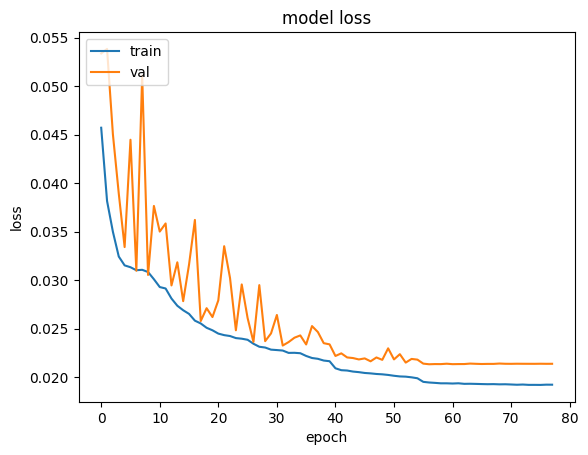

In [18]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss']+history6.history['loss']+history7.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss']+history6.history['val_loss']+history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

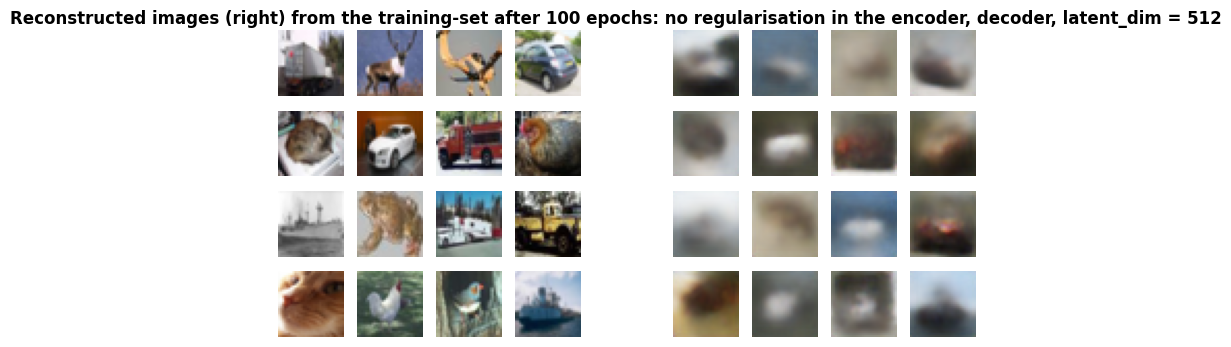

In [20]:
plot_reconstruction(img_train, 'training', 123, 100)

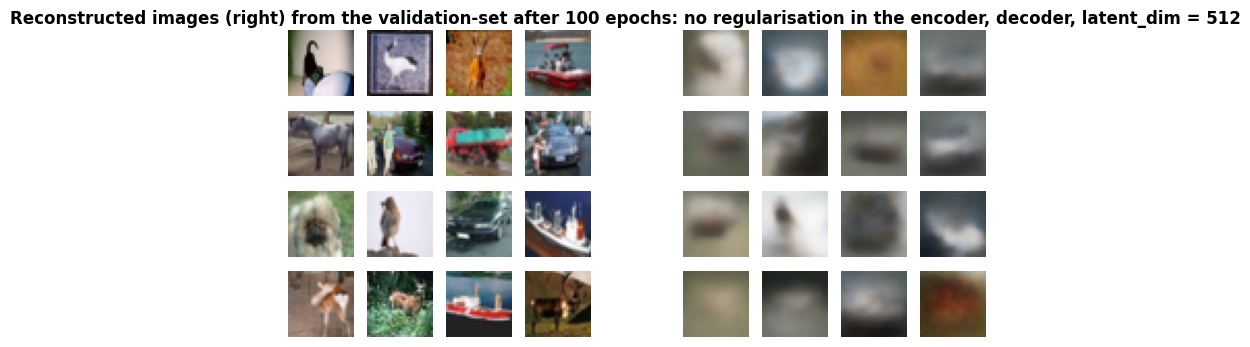

In [21]:
plot_reconstruction(img_valid, 'validation', 123, 100)

The images are smoother, because of the upsampling layer??